In [15]:
import pandas as pd
import sklearn.model_selection as ms
from sklearn import linear_model
from sklearn import preprocessing
import sklearn.metrics as sklm
import sklearn.decomposition as skde
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import math
import matplotlib as mpl
%matplotlib inline

In [16]:
Features = np.array(pd.read_csv('Features.csv'))
Labels = np.array(pd.read_csv('Labels.csv'))
print(Features.shape)
print(Labels.shape)

(70440, 178)
(70440, 1)


In [17]:
## Randomly sample cases to create independent training and test data
nr.seed(1115)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 10000)
X_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
X_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

In [18]:
pca_mod = skde.PCA()
pca_comps = pca_mod.fit(X_train)
pca_comps

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [19]:
print(pca_comps.explained_variance_ratio_)
print(np.sum(pca_comps.explained_variance_ratio_))

[  1.27092684e-01   8.69193255e-02   7.00217400e-02   6.08813911e-02
   5.26794412e-02   4.83694469e-02   4.58248364e-02   4.35119008e-02
   4.21333495e-02   3.60837502e-02   2.52500110e-02   2.39612655e-02
   2.07695333e-02   1.94316245e-02   1.86549507e-02   1.59466048e-02
   1.56102371e-02   1.30913505e-02   1.27073350e-02   1.16502133e-02
   1.12916586e-02   9.98601070e-03   9.58146902e-03   9.13460640e-03
   8.78715398e-03   8.51797540e-03   8.35493665e-03   7.90791902e-03
   7.61831717e-03   7.04221883e-03   6.44883279e-03   5.84534480e-03
   5.70373310e-03   5.31397077e-03   5.13789932e-03   5.07733075e-03
   4.63557093e-03   4.51597842e-03   4.38180464e-03   4.22871025e-03
   3.79015882e-03   3.54844205e-03   3.21676558e-03   3.09965243e-03
   3.07258556e-03   2.91172643e-03   2.77433470e-03   2.63179727e-03
   2.47260459e-03   2.41086975e-03   2.31032805e-03   2.26437846e-03
   2.10914723e-03   2.07312548e-03   1.93940875e-03   1.87656151e-03
   1.49551350e-03   1.44272588e-03

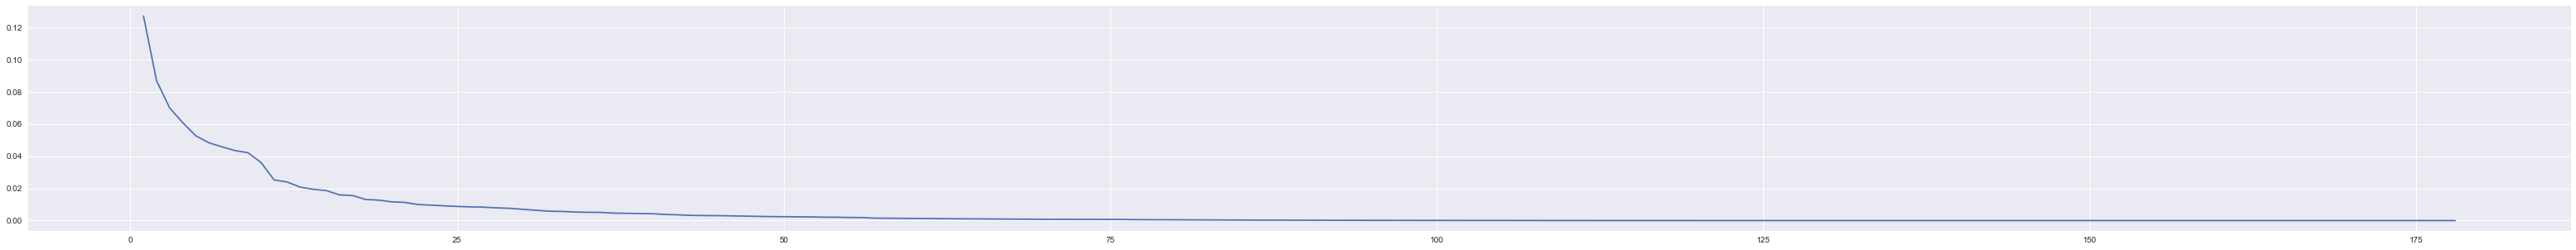

In [20]:
def plot_explained(mod):
    plt.figure(figsize=(55,5))
    comps = mod.explained_variance_ratio_
    x = range(len(comps))
    x = [y + 1 for y in x]          
    plt.plot(x,comps)
    mpl.style.use("seaborn")
plot_explained(pca_comps)

In [21]:
pca_mod_10 = skde.PCA(n_components = 20)
pca_mod_10.fit(X_train)
Comps = pca_mod_10.transform(X_train)
Comps.shape

(60440, 20)

In [22]:
## Define and fit the logistic regression model
log_mod_10 = linear_model.LogisticRegression(C = 10.0, class_weight = {0:0.45, 1:0.55}) 
log_mod_10.fit(Comps, y_train)
print(log_mod_10.intercept_)
print(log_mod_10.coef_)

[-0.59398799]
[[ 0.08113446 -0.02677684  0.17630803  0.16594316 -0.0143525  -0.05158726
  -0.06336539  0.00453653 -0.06227751 -0.0533359  -0.01583253  0.02141109
   0.13911282  0.01947557  0.05401006  0.02432456  0.05417638 -0.06952182
  -0.08897271  0.03062863]]


                 Confusion matrix
                 Score positive    Score negative
Actual positive      1654              5134
Actual negative       453              2759

Accuracy        0.44
AUC             0.60
Macro precision 0.57
Macro recall    0.55
 
           Positive      Negative
Num case     6788          3212
Precision    0.79          0.35
Recall       0.24          0.86
F1           0.37          0.50


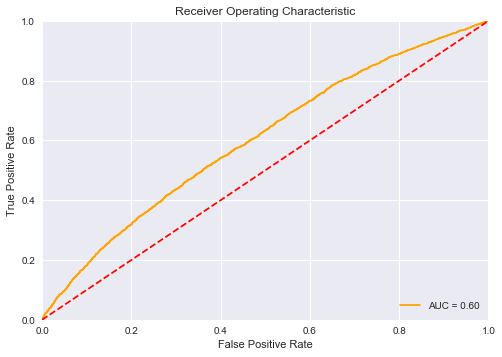

In [23]:
def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])

def print_metrics(labels, probs, threshold):
    scores = score_model(probs, threshold)
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy        %0.2f' % sklm.accuracy_score(labels, scores))
    print('AUC             %0.2f' % sklm.roc_auc_score(labels, probs[:,1]))
    print('Macro precision %0.2f' % float((float(metrics[0][0]) + float(metrics[0][1]))/2.0))
    print('Macro recall    %0.2f' % float((float(metrics[1][0]) + float(metrics[1][1]))/2.0))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])

def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()    

probabilities = log_mod_10.predict_proba(pca_mod_10.transform(X_test))
print_metrics(y_test, probabilities, 0.3)    
plot_auc(y_test, probabilities)     